# Object Detection with Classification & Localization

## 1. Importing Libraries

In [1]:
# Libs
import os
import numpy as np
import matplotlib.pyplot as plt
# image processing
import PIL.Image , PIL.ImageFont , PIL.ImageDraw

In [2]:
# Tensorflow Utils
import tensorflow as tf
import tensorflow_datasets as tfds

2025-08-27 07:45:56.213284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756280756.388499      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756280756.443444      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Visualization Utilities

In [3]:
def get_strategy():
    try:

        resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("TPU detected and initialized")
        return tf.distribute.TPUStrategy(resolver)

    except:

        gpus = tf.config.list_physical_devices('GPU')

        if gpus:
            print(f"GPU detected: {len(gpus)} available")
            return tf.distribute.MirroredStrategy()

        else:
            print("No GPU/TPU found, using CPU")
            return tf.distribute.get_strategy()

# Pick the best strategy automatically
strategy = get_strategy()

GPU detected: 1 available


I0000 00:00:1756280768.996320      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
# Image properties
im_width = 75
im_height = 75
use_normalized_coordinates = True

In [5]:
# Bounding Boxes
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax,
                               color='red', display_str_list=None,
                               thickness=1, use_normalized_coordinates=True):
    draw = PIL.ImageDraw.Draw(image)
    im_width, im_height = image.size

    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width,
                                      xmax * im_width,
                                      ymin * im_height,
                                      ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)

    # draw box
    draw.line([(left, top), (left, bottom),
               (right, bottom), (right, top), (left, top)],
              width=thickness, fill=color)


def draw_bounding_boxes_on_image(image, boxes, color=None, thickness=1, display_str_list=()):
    boxes_shape = boxes.shape

    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[-1] != 4:
        raise ValueError('Input must be of size [N,4]')

    for i in range(boxes_shape[0]):
        # pick color safely
        if isinstance(color, (list, tuple)) and len(color) > i:
            c = color[i]
        elif isinstance(color, str):
            c = color
        else:
            c = "red"   # default

        # pick display string safely
        d = display_str_list[i] if len(display_str_list) > i else None

        draw_bounding_box_on_image(
            image,
            boxes[i, 1], boxes[i, 0], boxes[i, 3], boxes[i, 2],
            color=c,
            display_str_list=d,
            thickness=thickness
        )


# Drawing bounding on numpy array image
def draw_bounding_boxes_on_image_array(image, boxes, color=None, thickness=1, display_str_list=()):
    image_pil = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new("RGBA", image_pil.size)
    rgbimg.paste(image_pil)

    draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
    return np.array(rgbimg)



In [6]:
# Long Execution Time
def dataset_to_numpy_util(training_dataset , validation_dataset):

  if tf.executing_eagerly():
    # Training Dataset
    for training_digits , (training_labels , training_bboxes) in training_dataset :
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      training_bboxes = training_bboxes.numpy()

    # Validation Dataset
    for validation_digits , (validation_labels , validation_bboxes) in validation_dataset :
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()


  return (training_digits , training_labels , training_bboxes ,
          validation_digits , validation_labels , validation_bboxes)


# Shorter Execution Time
def dataset_to_numpy_fast(training_dataset, validation_dataset, N):
    # Unbatch so each element is a single sample
    training_dataset = training_dataset.unbatch()
    validation_dataset = validation_dataset.unbatch()

    train_data = list(training_dataset.take(N))
    val_data   = list(validation_dataset.take(N))

    training_digits  = np.stack([x[0].numpy() for x in train_data])
    training_labels  = np.stack([x[1][0].numpy() for x in train_data])
    training_bboxes  = np.stack([x[1][1].numpy() for x in train_data])

    validation_digits = np.stack([x[0].numpy() for x in val_data])
    validation_labels = np.stack([x[1][0].numpy() for x in val_data])
    validation_bboxes = np.stack([x[1][1].numpy() for x in val_data])

    return (training_digits, training_labels, training_bboxes,
            validation_digits, validation_labels, validation_bboxes)

In [7]:
# Generating synthetic digit images from fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# n - number of images to be created
def create_digits_from_local_fonts(n):
  # font
  font_labels = []
  img = PIL.Image.new("LA" , ( 75, 75 * n ) , color =  (0 , 255))
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)

  # Draw images
  draw = PIL.ImageDraw.Draw(img)
  for i in range(n):
      font_labels.append(i % 10)
      draw.text((7 + i*75, 0 if i < 10 else -4),
            str(i % 10),
            fill=(255,255),
            font=font1 if i < 10 else font2)

  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0


  font_digits = np.reshape(
    np.stack(
        np.split(
            np.reshape(font_digits, [75, 75*n]),
            n, axis=1
        ),
        axis=0
    ),
    [n, 75*75]
  )


  return font_digits , font_labels


In [8]:
# # For displaying digits with boundingboxes
# def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou ,title):

#     #
#     iou_threshold = 0.6
#     # 10 images
#     n = 10
#     # randomly choosing
#     indexes = np.random.choice(len(predictions), size=n)

#     n_digits = digits[indexes]
#     n_predictions = predictions[indexes]
#     n_labels = labels[indexes]

#     n_iou = []
#     if len(iou) > 0:
#         n_iou = iou[indexes]

#     if len(pred_bboxes) > 0:
#         n_pred_bboxes = pred_bboxes[indexes]

#     if len(bboxes) > 0:
#         n_bboxes = bboxes[indexes]

#     n_digits = n_digits * 255.0
#     n_digits = n_digits.reshape(n, 75, 75)

#     fig = plt.figure(figsize=(25, 8))
#     plt.title(title)
#     plt.xticks([])
#     plt.yticks([])


#     for i in range(10):

#         ax = fig.add_subplot(1, 10, i + 1)
#         bboxes_to_plot = []

#         if (len(pred_bboxes) > i):
#             bboxes_to_plot.append(n_pred_bboxes[i])

#         if (len(bboxes) > i):
#             bboxes_to_plot.append(n_bboxes[i])

#         img_to_draw = draw_bounding_boxes_on_image_array(
#             image=n_digits[i],
#             boxes=np.asarray(bboxes_to_plot),
#             color=['red', 'green'],
#             display_str_list=['True', 'Pred']
#         )

#         plt.xlabel(n_predictions[i])
#         plt.xticks([])
#         plt.yticks([])

#         if np.argmax(n_predictions[i]) != np.argmax(n_labels[i]):
#           ax.xaxis.label.set_color('red')

#         plt.imshow(img_to_draw)
#         plt.tight_layout()
#         if len(iou) > i:
#             color = "black"
#             if (n_iou[i][0] < iou_threshold):
#                 color = "red"
#             ax.text(0.2, -0.3, "iou: %s" % (n_iou[i][0]), color=color, transform=ax.transAxes)

In [9]:
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):
    iou_threshold = 0.6
    n = 10
    indexes = np.random.choice(len(predictions), size=n, replace=False)

    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]

    n_iou = iou[indexes] if len(iou) > 0 else []
    n_pred_bboxes = pred_bboxes[indexes] if len(pred_bboxes) > 0 else []
    n_bboxes = bboxes[indexes] if len(bboxes) > 0 else []

    n_digits = n_digits * 255.0
    n_digits = n_digits.reshape(n, 75, 75)

    fig = plt.figure(figsize=(25, 8))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

    for i in range(n):
        ax = fig.add_subplot(1, n, i + 1)
        bboxes_to_plot = []
        colors = []
        display_strs = []

        if len(n_pred_bboxes) > i:
            bboxes_to_plot.append(n_pred_bboxes[i])
            colors.append('red')
            display_strs.append('Pred')
        if len(n_bboxes) > i:
            bboxes_to_plot.append(n_bboxes[i])
            colors.append('green')
            display_strs.append('True')

        img_to_draw = draw_bounding_boxes_on_image_array(
            image=n_digits[i].astype(np.uint8),
            boxes=np.asarray(bboxes_to_plot),
            color=colors,
            display_str_list=display_strs
        )

        # Get predicted and true label as class index
        pred_label = np.argmax(n_predictions[i]) if n_predictions[i].ndim > 0 else n_predictions[i]
        true_label = np.argmax(n_labels[i]) if n_labels[i].ndim > 0 else n_labels[i]
        ax.set_xlabel(f"P:{pred_label} / T:{true_label}")
        if pred_label != true_label:
            ax.xaxis.label.set_color('red')

        plt.xticks([])
        plt.yticks([])
        plt.imshow(img_to_draw)
        plt.tight_layout()

        if len(n_iou) > i:
            color = "black" if n_iou[i][0] >= iou_threshold else "red"
            ax.text(0.2, -0.3, f"iou: {n_iou[i][0]:.2f}", color=color, transform=ax.transAxes)

In [10]:
# Plot Metrics / Evaluation
def plot_metrics(metrics_name , title) :
  plt.title(title)
  plt.plot(history.history[metrics_name] , label = metrics_name)
  plt.plot(history.history["val_" + metrics_name] , label = "val_" + metrics_name)
  plt.legend()
  plt.show()

## 3. Loading & Preprocessing Dataset

In [11]:
# strategy = tf.distribute.get_strategy()
# List available devices

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.TPUStrategy(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))


In [12]:
# Batch size

BATCH_SIZE = 64*strategy.num_replicas_in_sync

In [13]:
def read_image_tfds(image, label):

    xmin = tf.random.uniform((), 0, 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0, 48, dtype=tf.int32)

    image = tf.reshape(image, (28,28,1))


    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)

    image = tf.cast(image, tf.float32) / 255.0

    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75

    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])



In [14]:
# Training Dataset
def get_training_dataset():
    with strategy.scope():
        dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat()
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(-1)
        return dataset

In [15]:
# Validation Dataset
def get_validation_dataset():
    with strategy.scope():
        dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.repeat()
        dataset = dataset.batch(10000, drop_remainder=True)
        return dataset


In [16]:
# datasets
with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.36HGXV_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.36HGXV_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [17]:
(training_digits , training_labels , training_bboxes ,
 validation_digits , validation_labels , validation_bboxes) = dataset_to_numpy_fast(training_dataset , validation_dataset , 10)

### Visualize Data

/tmp/ipykernel_36/2911078125.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


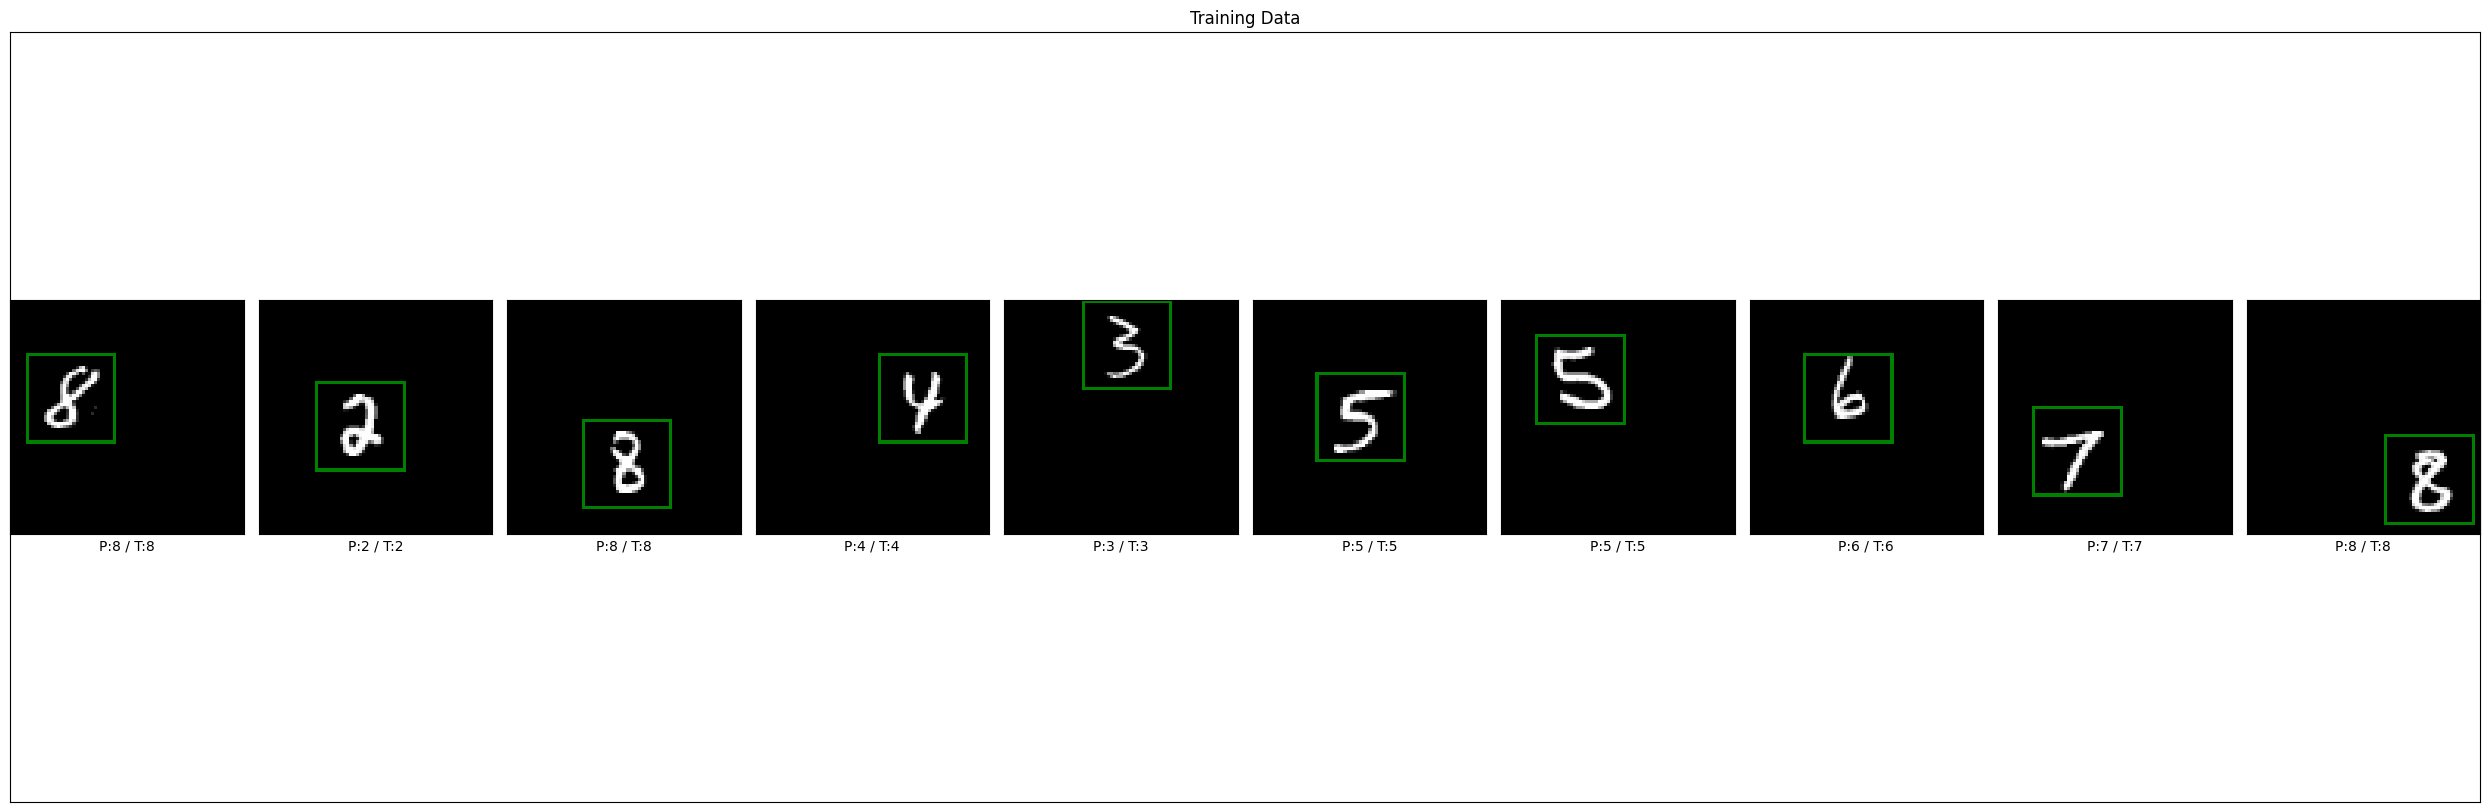

In [18]:
display_digits_with_boxes(training_digits , training_labels , training_labels, np.array([]),
                          training_bboxes , np.array([]) , "Training Data")

In [19]:
print(training_digits.shape , training_labels.shape , training_bboxes.shape )

(10, 75, 75, 1) (10, 10) (10, 4)


In [20]:
print(validation_digits.shape , validation_labels.shape , validation_bboxes.shape )

(10, 75, 75, 1) (10, 10) (10, 4)


/tmp/ipykernel_36/2911078125.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


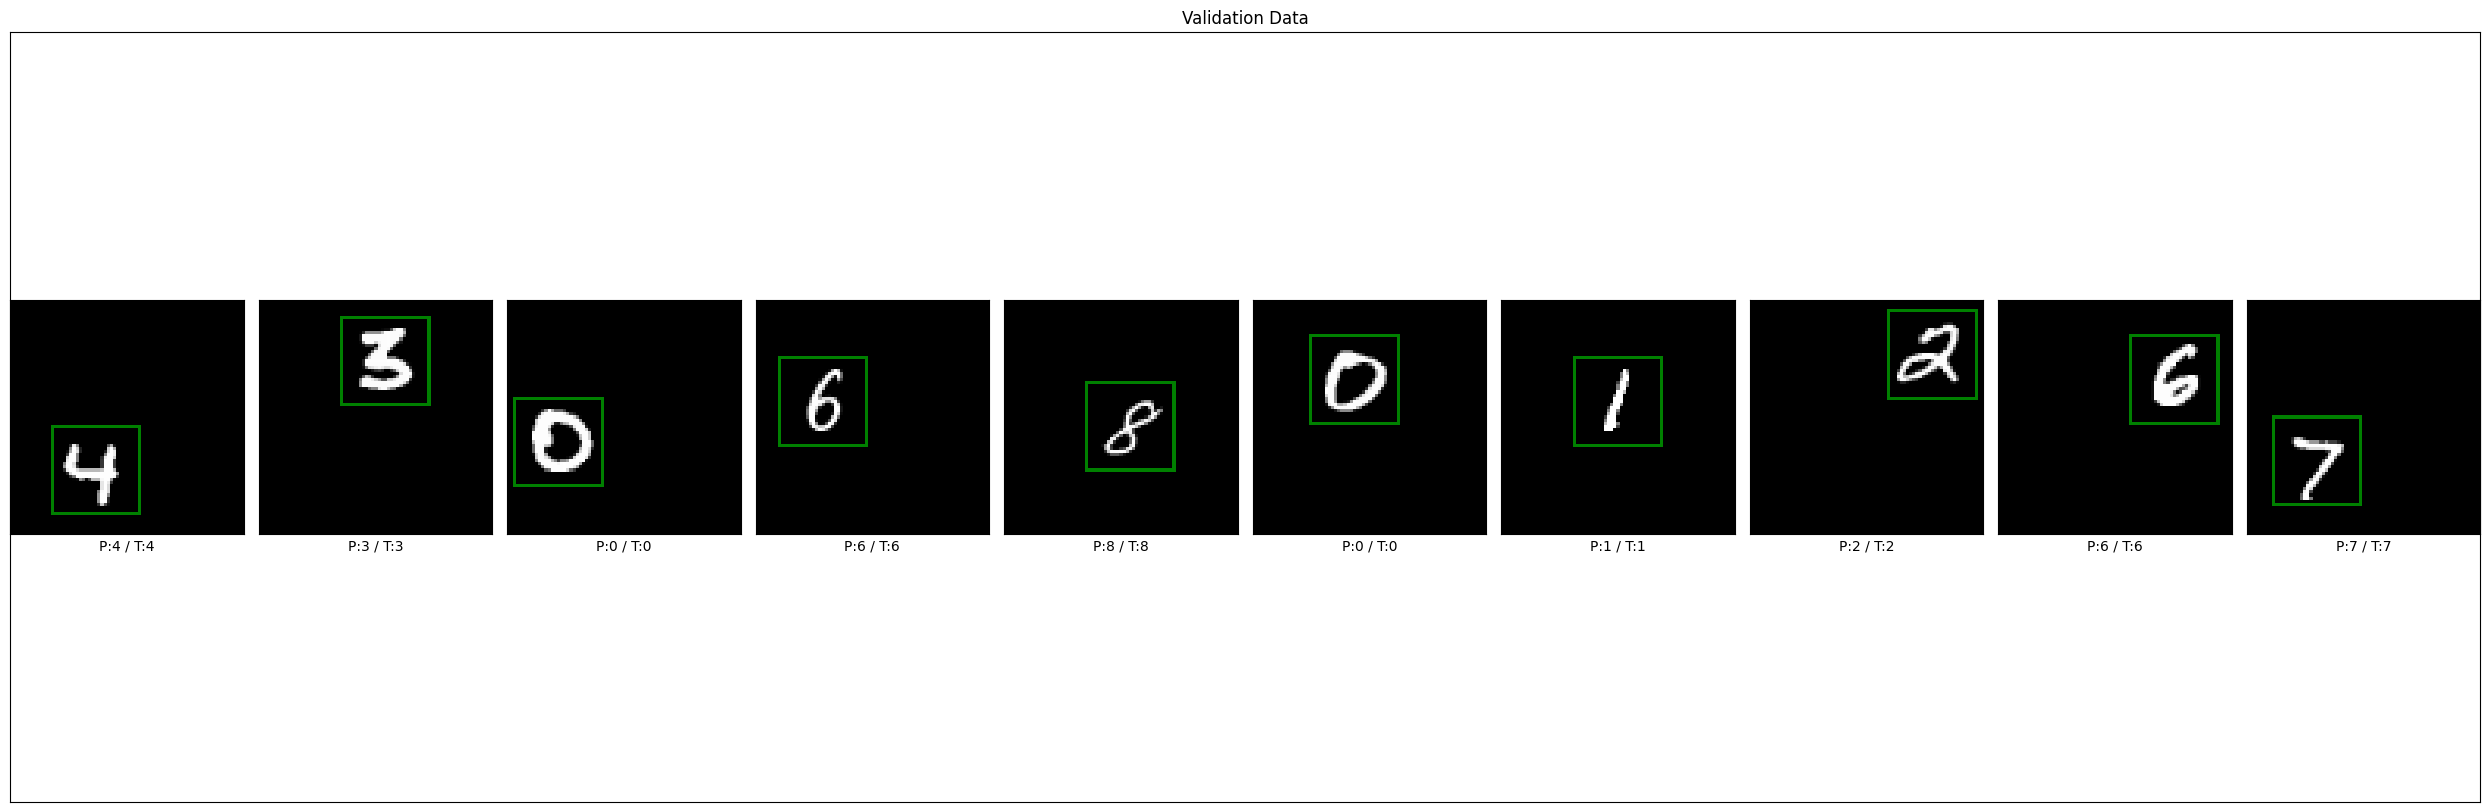

In [21]:
display_digits_with_boxes(validation_digits , validation_labels
                          , validation_labels,
                          np.array([]) , validation_bboxes , np.array([]) , "Validation Data")

## 4. Define The Network

In [22]:
# CNN
def feature_extraction(inputs):
  x = tf.keras.layers.Conv2D(16 , activation = 'relu'  , kernel_size = 3 , input_shape = (75 , 75 , 1))(inputs)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(32 , activation = 'relu'  , kernel_size = 3 )(x)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(64 , activation = 'relu'  , kernel_size = 3 )(x)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)

  return x


In [23]:
# Dense layers
def dense_layer(inputs) :
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128 , activation = "relu")(x)
  return x

In [24]:
# Output layers
def classifier(inputs):
  classification_output = tf.keras.layers.Dense(10 , activation = "softmax"  , name = "classification")(inputs)
  return classification_output


In [25]:
# BBox Regression
def bbox_regressor(inputs):
  bbox_regression = tf.keras.layers.Dense(4 , name = "bounding_box")(inputs)
  return bbox_regression

In [26]:
# Model
def final_model(inputs):
  feature_cnn = feature_extraction(inputs)
  dense_output = dense_layer(feature_cnn)

  # outputs
  classification_output = classifier(dense_output)
  bbox_regression = bbox_regressor(dense_output)

  model = tf.keras.Model(inputs = inputs , outputs = [classification_output , bbox_regression])
  return model

In [27]:
# definition and compile
def define_and_compile_model(inputs):
  model = final_model(inputs)

  model.compile(
                optimizer = "adam" ,
                loss = {
                        "classification": "categorical_crossentropy" ,
                        "bounding_box":"mse"
                        },
                metrics = {
                    "classification":"accuracy" ,
                    "bounding_box":"mse"
                }
                )

  return model

In [28]:
with strategy.scope():
  input = tf.keras.layers.Input(shape = (75,75,1))
  model = define_and_compile_model(input)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 36, 36,    │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 17, 17,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 7, 7, 64)  │          0 │ conv2d_2[0][0]    │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 10)        │      1,290 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bounding_box        │ (None, 4)         │        516 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 426,638 (1.63 MB)

 Trainable params: 426,638 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Train and Validate The Model

In [29]:
EPOCHS = 20
# EPOCHS = 5

steps_per_epoch = 60000 // BATCH_SIZE
history = model.fit(training_dataset ,
                    epochs = EPOCHS ,
                    steps_per_epoch = steps_per_epoch ,
                    validation_data = validation_dataset ,
                    validation_steps = 1)

loss , classification_loss , bbox_loss , classification_accuracy , bbox_accuracy = model.evaluate(validation_dataset , steps = 1)



W0000 00:00:1756280831.052036      36 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/20


I0000 00:00:1756280833.464961      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


935/937 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - bounding_box_loss: 0.0246 - bounding_box_mse: 0.0246 - classification_accuracy: 0.4076 - classification_loss: 1.6118 - loss: 1.6364

W0000 00:00:1756280842.279845      36 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


937/937 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - bounding_box_loss: 0.0246 - bounding_box_mse: 0.0246 - classification_accuracy: 0.4083 - classification_loss: 1.6098 - loss: 1.6344 - val_bounding_box_loss: 0.0075 - val_bounding_box_mse: 0.0075 - val_classification_accuracy: 0.9074 - val_classification_loss: 0.2977 - val_loss: 0.3051
Epoch 2/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - bounding_box_loss: 0.0066 - bounding_box_mse: 0.0066 - classification_accuracy: 0.9122 - classification_loss: 0.2868 - loss: 0.2934 - val_bounding_box_loss: 0.0040 - val_bounding_box_mse: 0.0040 - val_classification_accuracy: 0.9452 - val_classification_loss: 0.1807 - val_loss: 0.1846
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - bounding_box_loss: 0.0035 - bounding_box_mse: 0.0035 - classification_accuracy: 0.9426 - classification_loss: 0.1893 - loss: 0.1928 - val_bounding_box_loss: 0.0025 - val_bounding_box_mse: 0.0025 - val_classification_accuracy: 0.9595 - val_classification_loss: 0.1368 - val_

W0000 00:00:1756281027.610771      36 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step - bounding_box_loss: 9.5956e-04 - bounding_box_mse: 9.5956e-04 - classification_accuracy: 0.9891 - classification_loss: 0.0359 - loss: 0.0368


In [30]:
model.evaluate(validation_dataset , steps = 1)

W0000 00:00:1756281029.224467      36 auto_shard.cc:553] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step - bounding_box_loss: 9.5778e-04 - bounding_box_mse: 9.5778e-04 - classification_accuracy: 0.9881 - classification_loss: 0.0386 - loss: 0.0395


[0.03954114019870758,
 0.03858335688710213,
 0.0009577846503816545,
 0.0009577846503816545,
 0.988099992275238]

In [31]:
history.history

{'bounding_box_loss': [0.0158363189548254,
  0.005593311507254839,
  0.0031571355648338795,
  0.0022787388879805803,
  0.0017679085722193122,
  0.0014387342380359769,
  0.0012842618161812425,
  0.0011546844616532326,
  0.0010518142953515053,
  0.0010322834132239223,
  0.001001850701868534,
  0.0009563436033204198,
  0.0009687290876172483,
  0.0010610134340822697,
  0.0010471256682649255,
  0.0009886412881314754,
  0.0010153008624911308,
  0.0010015482548624277,
  0.0010471551213413477,
  0.0010676780948415399],
 'bounding_box_mse': [0.0158363189548254,
  0.005593311507254839,
  0.0031571355648338795,
  0.0022787388879805803,
  0.0017679085722193122,
  0.0014387342380359769,
  0.0012842618161812425,
  0.0011546844616532326,
  0.0010518142953515053,
  0.0010322834132239223,
  0.001001850701868534,
  0.0009563436033204198,
  0.0009687290876172483,
  0.0010610134340822697,
  0.0010471256682649255,
  0.0009886412881314754,
  0.0010153008624911308,
  0.0010015482548624277,
  0.00104715512134

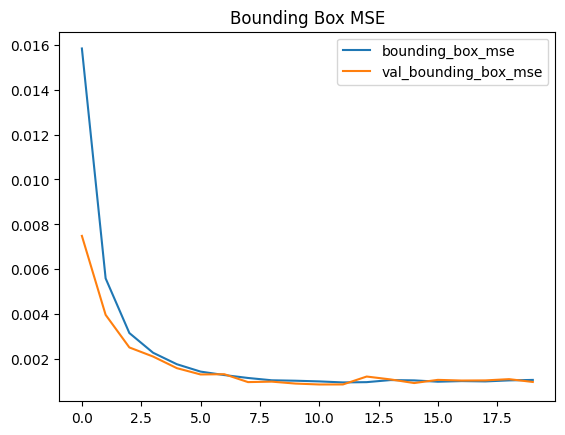

In [32]:
plot_metrics("bounding_box_mse" , "Bounding Box MSE")

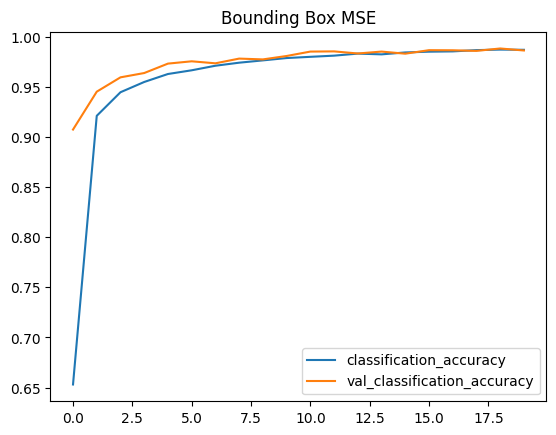

In [33]:
plot_metrics("classification_accuracy" , "Bounding Box MSE")

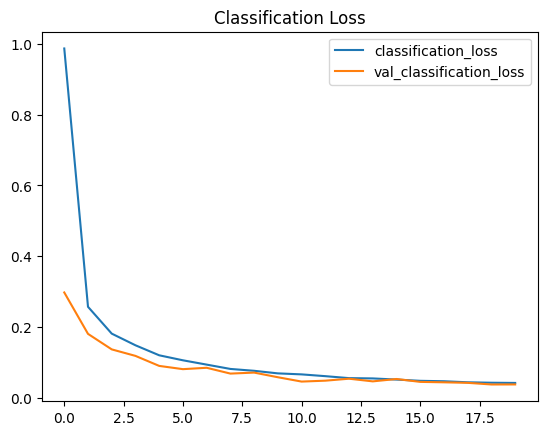

In [34]:
plot_metrics("classification_loss" , "Classification Loss")

In [35]:
# Bounding box eval
def intersection_over_union(pred_box , true_box):
  xmin_pred , ymin_pred , xmax_pred , ymax_pred = np.split(pred_box , 4 , axis = 1)
  xmin_true , ymin_true , xmax_true , ymax_true = np.split(true_box , 4 , axis = 1)

  smoothing_factor = 1e-10
  xmin_overlap = np.maximum(xmin_pred , xmin_true)
  xmax_overlap = np.minimum(xmax_pred , xmax_true)
  ymin_overlap = np.maximum(ymin_pred , ymin_true)
  ymax_overlap = np.minimum(ymax_pred , ymax_true)

  pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
  true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

  overlap_area = np.maximum(0 , xmax_overlap - xmin_overlap) * np.maximum(0 , ymax_overlap - ymin_overlap)
  union_area = pred_box_area + true_box_area - overlap_area

  iou = overlap_area / (union_area + smoothing_factor)

  return iou

/tmp/ipykernel_36/2911078125.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


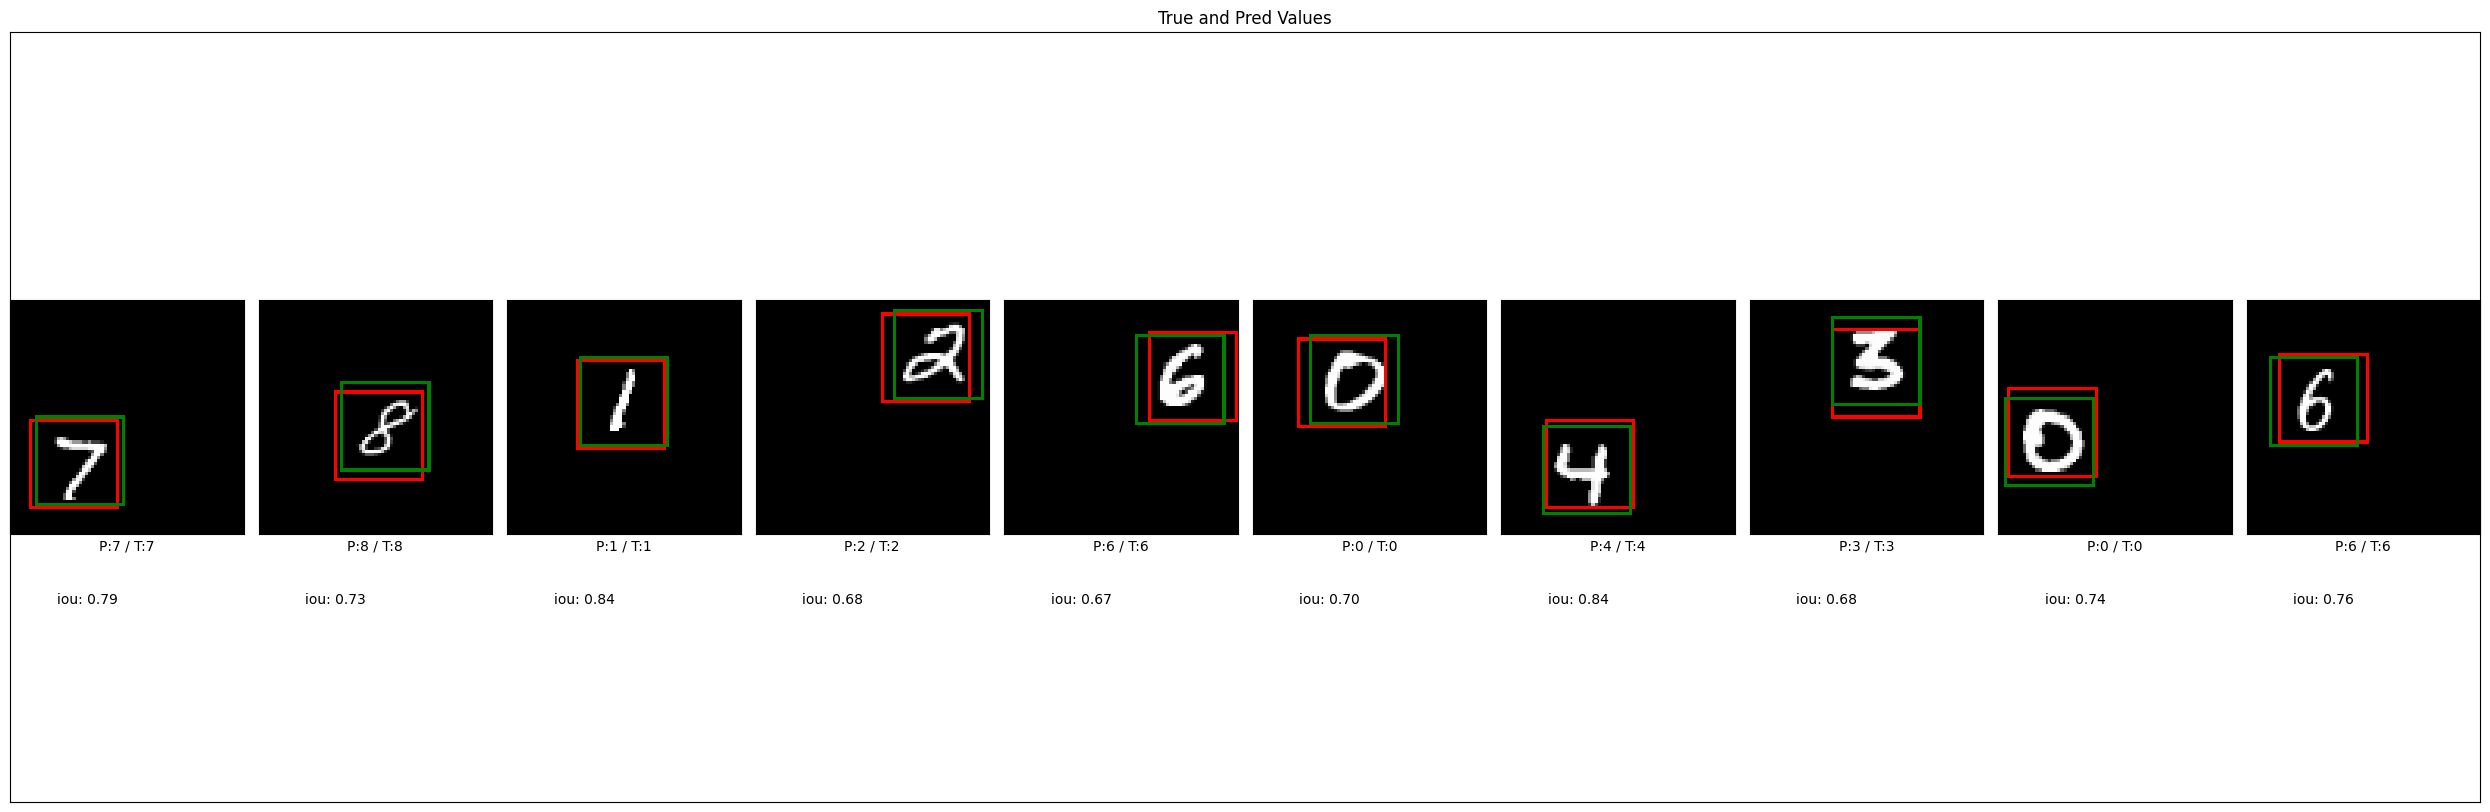

In [36]:
prediction = model.predict(validation_digits , batch_size = 64 , verbose = 0)

prediction_labels = np.argmax(prediction[0] , axis = 1)

prediction_bboxes = prediction[1]

iou = intersection_over_union(prediction_bboxes , validation_bboxes)

display_digits_with_boxes(validation_digits ,
                          prediction_labels , validation_labels,
                          prediction_bboxes , validation_bboxes , iou ,
                           "True and Pred Values")